In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Reshape, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

In [2]:
# GAN  생성자 네트워크

latent_dim = 32
height = 32
width = 32 
channels = 3

In [3]:
generator_input = Input(shape = (latent_dim,))
x = Dense(128 * 16 * 16)(generator_input)
x = LeakyReLU()(x)
x = Reshape((16,16,128))(x)

x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256,4,strides =2, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7, activation = 'tanh', padding = 'same')(x)

In [4]:
generator = Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [9]:
# GAN 판별자 네트워크

discriminator_input = Input(shape = (height, width, channels))

In [10]:
x = Conv2D(128, 3)(discriminator_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides =2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides =2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides =2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

In [11]:
discriminator = Model(discriminator_input, x)
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6, 6, 128)         0   

In [12]:
from tensorflow.keras.optimizers import RMSprop

In [14]:
discriminator_optimizer = RMSprop(learning_rate = 0.0008, clipvalue = 1.0, decay = 1e-8)
discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy')

In [15]:
# 적대적 네트워크 
discriminator.trainable = False

gan_input = Input(shape = (latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(learning_rate=0.0004, clipvalue = 1.0, decay = 1e-8)
gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy')

In [16]:
# DCGAN 구현
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image

In [17]:
(x_train, y_train),(_,_) = cifar10.load_data()

In [18]:
x_train = x_train[y_train.flatten()==6]

In [20]:
x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [21]:
iterations = 10000
batch_size = 20 

save_dir = 'D:\\Image\\'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [23]:
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 ==0:
        gan.save_weights('gan.h5')
        
        print('\nstep : {}'.format(step))
        print('discriminator loss : {}'.format(d_loss))
        print(' adversarial loss : {}'.format(a_loss))
        
        img = image.array_to_img(generated_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, ' real_frog' + str(step)+ '.png'))


step : 0
discriminator loss : 0.7018159627914429
 adversarial loss : 0.7113341093063354

step : 100
discriminator loss : 0.6687629818916321
 adversarial loss : 1.2909153699874878

step : 200
discriminator loss : 0.7172495722770691
 adversarial loss : 0.7067634463310242

step : 300
discriminator loss : 0.6994584798812866
 adversarial loss : 0.7430504560470581

step : 400
discriminator loss : 0.6964761018753052
 adversarial loss : 0.7581477761268616

step : 500
discriminator loss : 0.7012076377868652
 adversarial loss : 0.7228667140007019

step : 600
discriminator loss : 0.6940518617630005
 adversarial loss : 0.742066502571106

step : 700
discriminator loss : 0.7002584338188171
 adversarial loss : 0.7379345297813416

step : 800
discriminator loss : 0.7118936777114868
 adversarial loss : 0.7376884818077087

step : 900
discriminator loss : 0.7053279876708984
 adversarial loss : 0.7282673716545105

step : 1000
discriminator loss : 0.6955627202987671
 adversarial loss : 0.7598193287849426



In [24]:
import matplotlib.pyplot as plt

In [25]:
random_latent_vectors = np.random.normal(size = (10, latent_dim))

In [26]:
generated_images = generator.predict(random_latent_vectors)

In [27]:
print(generated_images.shape)


(10, 32, 32, 3)


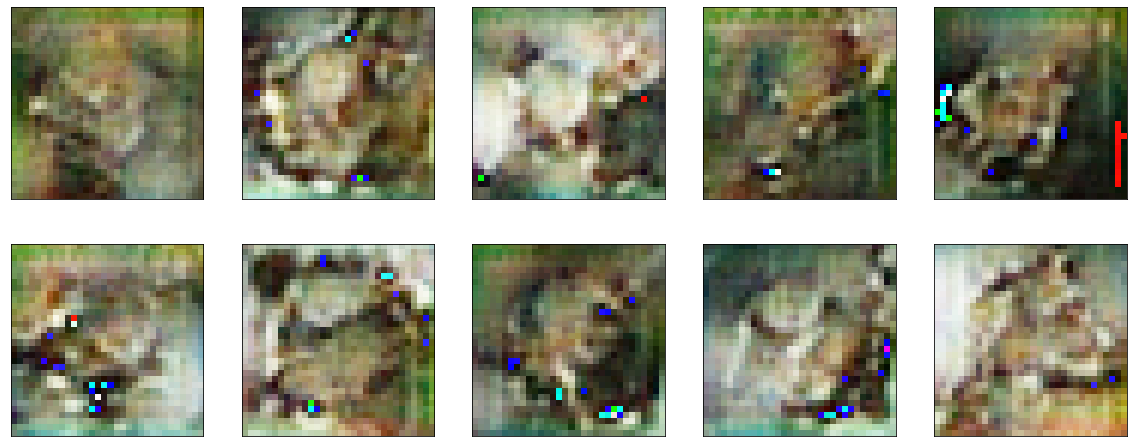

In [28]:
plt.figure(figsize = (20, 8))
for i in range(generated_images.shape[0]):
    plt.subplot(2, 5, i+1)
    img = image.array_to_img(generated_images[i] * 255., scale = False)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
plt.show()